## Image classification with Convolutional Neural Networks

Welcome to the first week of the second deep learning certificate! We're going to use convolutional neural networks (CNNs) to allow our computer to see - something that is only possible thanks to deep learning.

## Introduction to our first task: 'Glass vs Tables'

https://www.kaggle.com/mbkinaci/glasses-tables/version/1

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Here we import the libraries we need. We'll learn about what each does during the course.

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/anaconda3/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "../../../data/glass-table/"

In [5]:
sz=48

In [21]:
arch=resnet50

In [22]:
!ls {PATH}

models test   tmp    train  valid


In [23]:
!ls {PATH}valid

glass table


In [24]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

#### Add data augmentation

In [25]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=None)

In [26]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=4, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [27]:
ims = np.stack([get_augs() for i in range(6)])

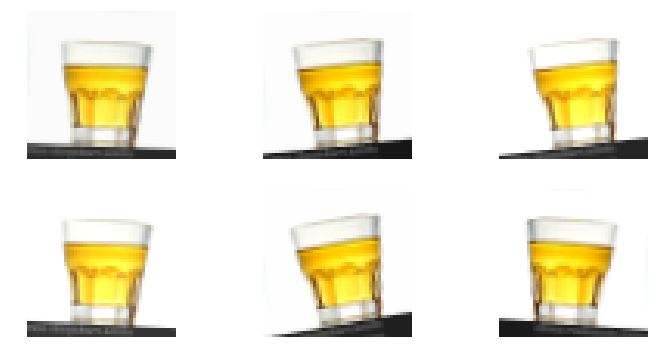

In [28]:
plots(ims, rows=2)

In [29]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')

In [30]:
learn = ConvLearner.pretrained(arch, data, precompute=False)

In [31]:
lrf=learn.lr_find()

 92%|█████████▏| 84/91 [01:30<00:07,  1.12s/it, loss=1.21] 

Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

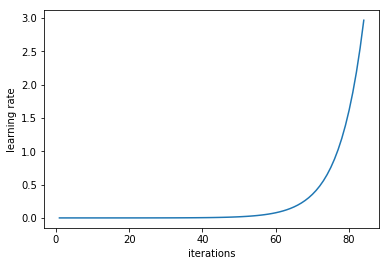

In [32]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

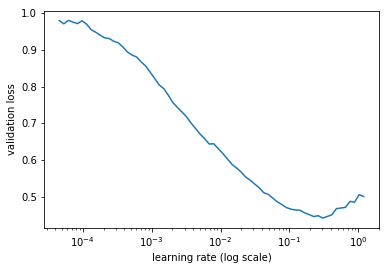

In [33]:
learn.sched.plot()

In [34]:
#lr = 0.08 #resnext34
lr = 0.15 #resnext50
#learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.fit(lr, 3, cycle_len=1)
#learn.fit(0.008, 3) - 99.365

epoch      trn_loss   val_loss   accuracy                  
    0      0.507344   0.191098   0.952077  
    1      0.295187   0.107489   0.971246                  
    2      0.194132   0.099891   0.969649                  


[array([0.09989]), 0.9696485623003195]

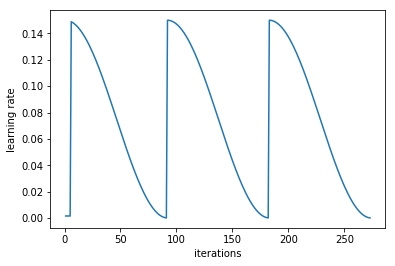

In [36]:
learn.sched.plot_lr()

## Analyzing results: looking at pictures

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (i.e. those with highest probability that are correct)
4. The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
5. The most uncertain labels (i.e. those with probability closest to 0.5).

In [61]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['glass', 'table']

In [62]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(626, 2)

In [63]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
print("predications : " + str(preds[:10]))
print("Probabilities : " + str(probs[:5]))

print("probs max : " + str(probs.max()))
print("probs min : " + str(probs.min()))

predications : [0 0 0 0 0 0 0 0 0 0]
Probabilities : [0.      0.00007 0.00007 0.00001 0.     ]
probs max : 1.0
probs min : 1.1058261e-13


In [64]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [65]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [66]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [67]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [68]:
def count_preds(is_correct): 
    print(np.where(((preds == data.val_y) == is_correct)))
    return len( ((preds == data.val_y) == is_correct) ) 
    

Correctly classified


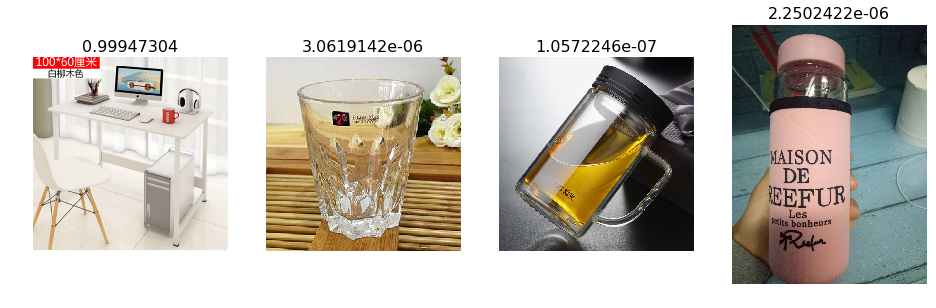

In [69]:
# 1. A few correct labels at random
#print(count_preds(True))

plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


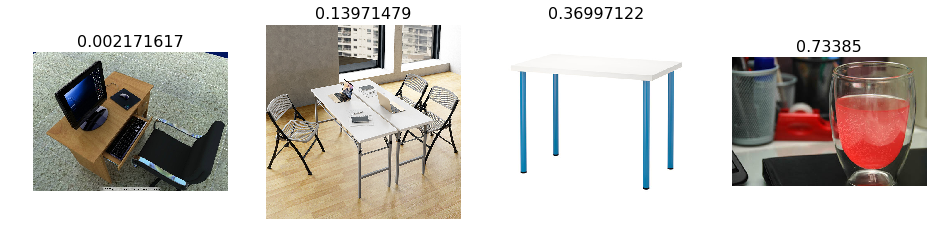

In [70]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [71]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct glass


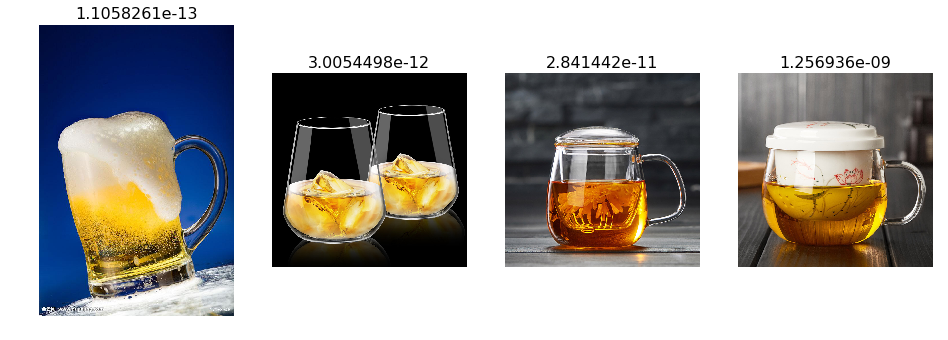

In [72]:
plot_val_with_title(most_by_correct(0, True), "Most correct glass")

Most correct tables


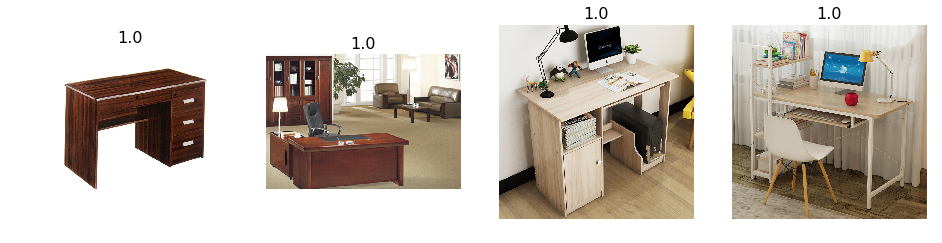

In [73]:
plot_val_with_title(most_by_correct(1, True), "Most correct tables")

Most incorrect glass


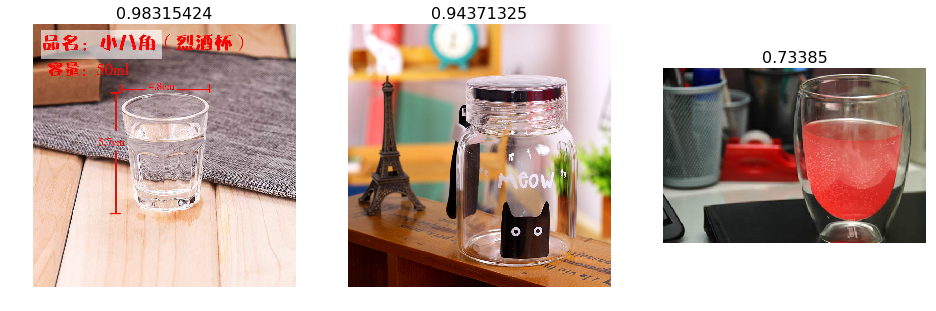

In [74]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect glass")

Most incorrect tables


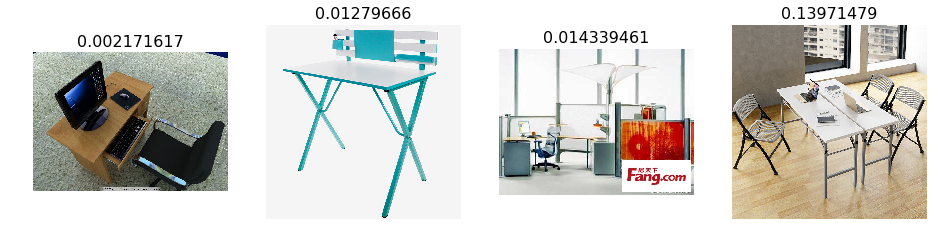

In [75]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect tables")

Most uncertain predictions


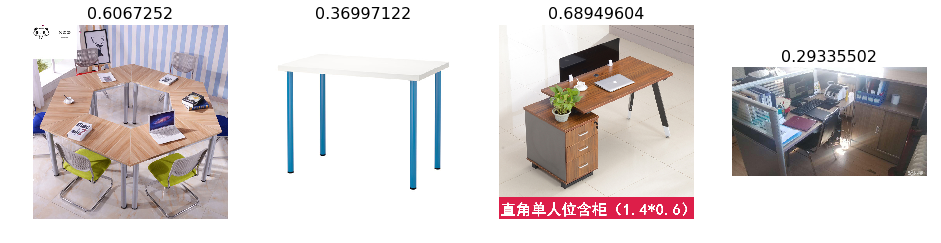

In [76]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

##### Save the model weights

In [53]:
learn.save('48_lastlayer')

In [54]:
learn.load('48_lastlayer')

## Improving our model

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. To tell the learner that we want to unfreeze the remaining layers, just call (surprise surprise!) `unfreeze()`.

In [55]:
learn.unfreeze()

In [56]:
lrs=np.array([lr/100, lr/10, lr])
lrs

array([0.0015, 0.015 , 0.15  ])

In [57]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.168519   0.072949   0.976038  
    1      0.108232   0.044886   0.985623                  
    2      0.057405   0.044061   0.98722                    
    3      0.064859   0.043783   0.984026                   
    4      0.042163   0.046997   0.98722                    
    5      0.031553   0.041279   0.988818                   
    6      0.019718   0.050515   0.984026                   


[array([0.05052]), 0.9840255591054313]

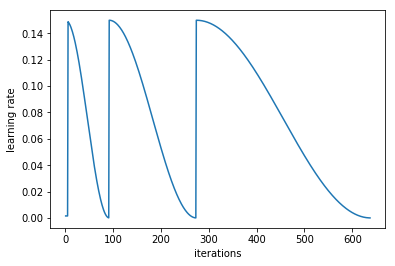

In [58]:
learn.sched.plot_lr()

In [59]:
learn.save('48_all')

In [60]:
learn.load('48_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [77]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [78]:
probs[:2]

array([[1.     , 0.     ],
       [0.99994, 0.00006]], dtype=float32)

In [79]:
probs.shape

(626, 2)

In [80]:
accuracy_np(probs, y)

0.9856230031948882

In [81]:
test_log_preds,test_y = learn.TTA(is_test=True)

In [82]:
test_probs = np.mean(np.exp(test_log_preds), 0)
print(test_probs.shape)
print(test_probs[:4])

(1243, 2)
[[0.99999 0.00001]
 [0.00005 0.99995]
 [1.      0.     ]
 [0.00025 0.99975]]


In [83]:
print('Test accuracy : {0:2f}'.format(accuracy_np(test_probs, test_y)))

Test accuracy : 0.562349


In [84]:
isDog = test_probs[:,1]
print(isDog.shape)
print(len(isDog))
print(isDog[:5])


(1243,)
1243
[0.00001 0.99995 0.      0.99975 0.00038]


In [85]:
test_ds = learn.data.test_ds
print(test_ds)
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(test_filenames[:5])
print(test_dl.dataset.y.max())

['test/glass_3478.jpg', 'test/table_3659.jpg', 'test/glass_3444.jpg', 'test/table_3671.jpg', 'test/glass_3322.jpg']
0.0


In [88]:
fileIds = np.array([f[5:f.find('.')] for f in test_filenames])
fileIds[:5]

array(['glass_3478', 'table_3659', 'glass_3444', 'table_3671', 'glass_3322'], dtype='<U10')

In [89]:
submission = np.stack([fileIds,isDog], axis=1)
submission[:5]


array([['glass_3478', '9.859892e-06'],
       ['table_3659', '0.9999453'],
       ['glass_3444', '2.5492404e-06'],
       ['table_3671', '0.99974716'],
       ['glass_3322', '0.0003783392']], dtype='<U32')

In [90]:
!pwd

/Users/zc/programming/DL/fast.ai/fastai/courses/dl1


In [92]:
submission_file_name = 'submission1.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%.10f', header='id,label', comments='')

TypeError: Mismatch between array dtype ('<U32') and format specifier ('%s,%.10f')

In [ ]:
from IPython.display import FileLink
FileLink(submission_file_name)

I generally see about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!

## Analyzing results

### Confusion matrix 

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
# test dataset
#preds = np.argmax(test_probs, axis=1)
#probs = test_probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

In [ ]:
plot_confusion_matrix(cm, data.classes)

### Looking at pictures again

In [ ]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect glass")

In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect tables")